# 4. PyTorch Custom datasets

## 0. Importing PyTorch and setting up device-agnostic code


In [4]:
import torch
from torch import nn

# Check version of PyTorch
torch.__version__

'2.0.0+cu117'

In [5]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

We will take only 3 classes of food and only 10% of the images (~75 training, 25 testing images).

When staring out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

In [6]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza, steak and sushi data...")
    f.write(request.content)

# Unzip pizza, steak and sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print(f"Unziping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

# Remove zip file
Path.unlink(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory already exists... skipping download
Unziping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [7]:
import os 

def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    
    for dirpath, dirnames, filenamse in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenamse)} images in '{dirpath}'.")

In [8]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [9]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/steak/3245622.jpg
Image class: steak
Image height: 262
Image width: 512


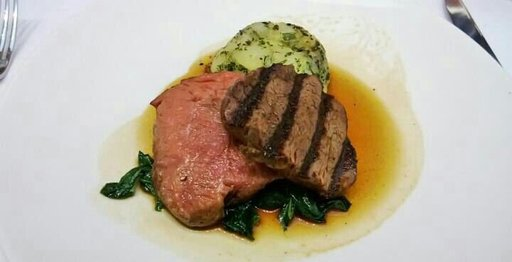

In [10]:
import random
from PIL import Image

# Set seed
# random.seed(100)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class name
random_image_class = random_image_path.parent.stem

# 4. Open image using PIL
img = Image.open(random_image_path)

# 5. Show image and print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {random_image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 261.5, -0.5)

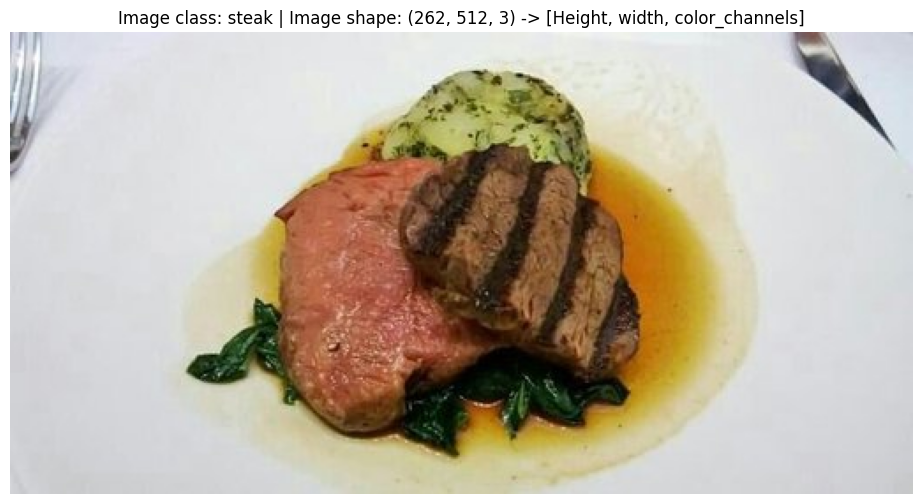

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib

plt.figure(figsize=(12,6))
plt.imshow(img_as_array)
plt.title(f"Image class: {random_image_class} | Image shape: {img_as_array.shape} -> [Height, width, color_channels]")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [13]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [17]:
data_transform(img).shape

torch.Size([3, 64, 64])

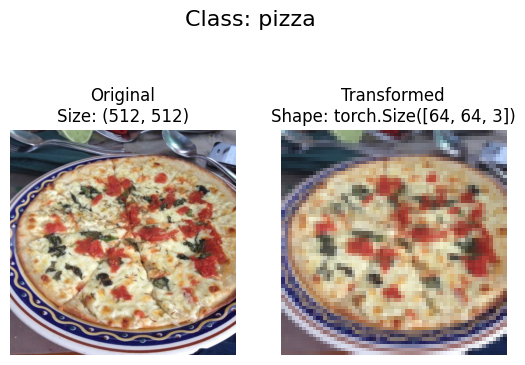

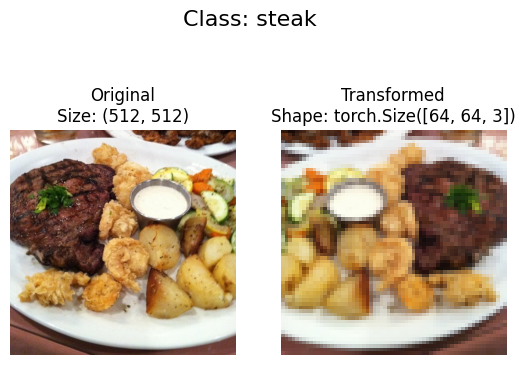

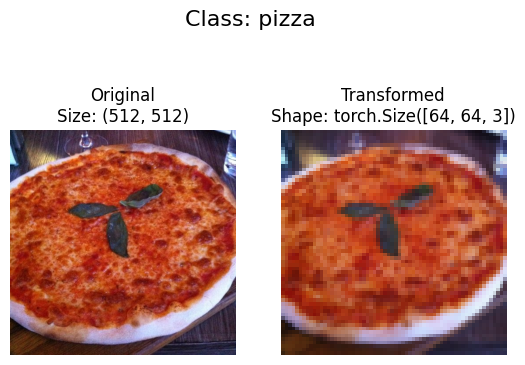

In [25]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=100):
    """Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version.

    Args:
        image_paths (list): Image path
        transform (_type_): _description_
        n (int, optional): Numbers of random samples. Defaults to 3.
        seed (int, optional): Seed for reapetable randomnes. Defaults to 100.
    """

    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [26]:
# Use ImageFolder to create dataset
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [28]:
# Get class names as a list
class_names = train_data.classes
# Get class names as a dict
class_dict = train_data.class_to_idx

class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [33]:
# index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channel, height, width]
Permuted shape: torch.Size([64, 64, 3]) -> [height, width, color_channel]


Text(0.5, 1.0, 'pizza')

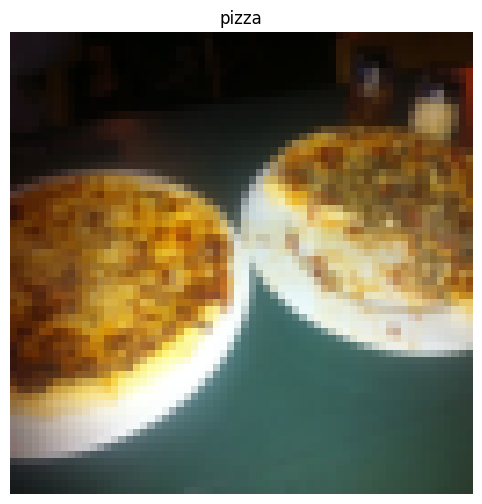

In [37]:
# Rearrange the order dimension
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channel, height, width]")
print(f"Permuted shape: {img_permute.shape} -> [height, width, color_channel]")

# Plot the image
plt.figure(figsize=(12, 6))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label])

### 4.1 Turn loaded images into `DataLoader`

In [40]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             num_workers=os.cpu_count(),
                             batch_size=BATCH_SIZE,
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(8, 3)

In [44]:
img, label = next(iter((train_dataloader)))

print(f"Image shape: {img.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([32])


## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as a dictionary from the Dataset

Pros: 
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons: 
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

In [45]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [47]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a fucntion to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [51]:
# Setup path for target directory

target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [52]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory. """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... Please check file structure.")
    
    # 3. Create a dictionary of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

In [56]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})